In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile
filename="/content/drive/My Drive/HAM10000.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("done")


done


In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
data_pd = pd.read_csv('/content/drive/MyDrive/HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
train_dir = os.path.join('HAM10000', 'train_dir')
test_dir = os.path.join('HAM10000', 'test_dir')

In [6]:
# This will tell us how many images are associated with each lesion_id.
df = data_pd.groupby('lesion_id').count()

# Now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [7]:
def identify_duplicates(x):

    # Generate a list of items with unique lesion ids from df array.
    unique_list = list(df['lesion_id'])

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

In [8]:

# create a new column that is a copy of the lesion_id column
data_pd['duplicates'] = data_pd['lesion_id']
# apply the function to this new column
data_pd['duplicates'] = data_pd['duplicates'].apply(identify_duplicates)

data_pd.head()

df = data_pd[data_pd['duplicates'] == 'no_duplicates']

# Now we create a test set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, test_df = train_test_split(df, test_size=0.15, random_state=101, stratify=y)



In [9]:
# This set will be data_pd excluding all rows that are in the test set

# This function identifies if an image is part of the train
# or test set.
def identify_test_rows(x):
    # create a list of all the lesion_id's in the test set
    test_list = list(test_df['image_id'])

    if str(x) in test_list:
        return 'test'
    else:
        return 'train'


# Copy image_id column to train_or_test column.
data_pd['train_or_test'] = data_pd['image_id']


# Apply identify_test_rows to this copied column.     
data_pd['train_or_test'] = data_pd['train_or_test'].apply(identify_test_rows)


# Add data that is part of the training dataset by using applied function and taking result.
train_df = data_pd[data_pd['train_or_test'] == 'train']




# Get a list of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])


In [10]:
len(train_list)

9187

In [11]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [12]:
os.mkdir(train_dir)
os.mkdir(test_dir)

In [13]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [14]:
for i in targetnames:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)


In [15]:
for image in train_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']


    # destination path to image
    source = os.path.join('HAM10000', file_name)

    # copy the image from the source to the destination
    dest = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, dest)

In [16]:

for image in test_list:

    # Set all file names as name + jpeg extension.
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # destination path to image
    source = os.path.join('HAM10000', file_name)

    # copy the image from the source to the destination
    dest = os.path.join(test_dir, label, file_name)

    shutil.copyfile(source, dest)

In [17]:


targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Create an augmented dataset which will expand the dataset of all image
# classes.
for item in targetnames:

    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Get class from class_list array. Represents respective file in HAM10000 dir.
    img_class = item

    # list all images in that directory
    img_list = os.listdir('HAM10000/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for file_name in img_list:

        # Create source directory which is in training directory.
        src = os.path.join('HAM10000/train_dir/' + img_class, file_name)

        # Create destination folder which is in image directory.
        dst = os.path.join(img_dir, file_name)

        # Copy all images from src -> dst folder.
        shutil.copyfile(src, dst)

    # Temporary augumented dataset directory, will be deleted upon training.
    path = aug_dir

    # Set our save path to training directory for all augmented imgs produced.
    save_path = 'HAM10000/train_dir/' + img_class

    # Create Datagen generator.
    # We will be using an ImageDataGenerator because we are processing
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,save_to_dir=save_path,save_format='jpg',target_size=(224, 224),batch_size=batch_size)

    # Generate the augmented images and add them to the training folders
    num_aug_images_wanted = 8000  # total number of images we want to have in each class

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

    # run the generator and create about 8000 augmented images
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

    # End for loop


Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [18]:

# BUILD MODEL

train_path = 'HAM10000/train_dir'
test_path = 'HAM10000/test_dir'

train_samples = len(train_df)
test_samples = len(test_df)

train_batch_size = 10
test_batch_size = 10
image_size = 224

# Divide total # of samples by batch size to section off training samples into steps.
# Then round up with np.ceil function.
train_steps = np.ceil(train_samples / train_batch_size)
test_steps = np.ceil(test_samples / test_batch_size)

# Create an Image Data Generator to input later into our model.
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)


### GETTING BATCHES FROM DIRECTORY PATHS ###
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size,
                                            shuffle=True)



print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=1,
                                           shuffle=False)



Train Batches: 
Found 51699 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


In [19]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()
 

In [20]:
resnet = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = resnet.layers[-3].output

102973440/102967424 [==============================] - 2s 0us/step


In [21]:

output = GlobalAveragePooling2D()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=resnet.input, outputs=output)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [24]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = 'ResNet50.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)




In [25]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=40, min_delta=0.001)
history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    epochs=300,
                    verbose=2,
                    validation_data=test_batches,validation_steps=len(test_df),callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/300
919/919 - 85s - loss: 1.9275 - accuracy: 0.4376 - val_loss: 0.8518 - val_accuracy: 0.8080
Epoch 2/300
919/919 - 76s - loss: 1.5601 - accuracy: 0.5326 - val_loss: 0.7295 - val_accuracy: 0.7657
Epoch 3/300
919/919 - 76s - loss: 1.3781 - accuracy: 0.5890 - val_loss: 0.4901 - val_accuracy: 0.8442
Epoch 4/300
919/919 - 76s - loss: 1.2963 - accuracy: 0.6118 - val_loss: 0.4910 - val_accuracy: 0.8382
Epoch 5/300
919/919 - 76s - loss: 1.1731 - accuracy: 0.6502 - val_loss: 0.6289 - val_accuracy: 0.8031
Epoch 6/300
919/919 - 76s - loss: 1.0880 - accuracy: 0.6729 - val_loss: 0.4986 - val_accuracy: 0.8309
Epoch 7/300
919/919 - 76s - loss: 1.0301 - accuracy: 0.6900 - val_loss: 0.7125 - val_accuracy: 0.7367
Epoch 8/300
919/919 - 76s - loss: 0.9887 - accuracy: 0.7017 - val_loss: 0.6859 - val_accuracy: 0.8140
Epoch 9/300
919/919 - 76s - loss: 0.9602 - accuracy: 0.7201 - val_loss: 0.7569 - val_accuracy: 0.7307
Epoch 10/300
919/919 - 76s - loss: 0.9136 - accuracy: 0.7293 - val_loss: 0.3537 - 

In [26]:
from tensorflow.keras import models
model.load_weights("ResNet50.hdf5")

In [27]:
predictions = model.predict(test_batches, steps=len(test_df), verbose=1)

828/828 [==============================] - 9s 10ms/step


In [28]:

y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
# Get the labels of the test images.
y_true = test_batches.classes
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Create classification report with matrix labels and target names.
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.74      0.74      0.74        23
         bcc       0.91      0.77      0.83        26
         bkl       0.67      0.50      0.57        66
          df       0.80      0.67      0.73         6
         mel       0.52      0.50      0.51        34
          nv       0.95      0.98      0.96       663
        vasc       0.90      0.90      0.90        10

    accuracy                           0.90       828
   macro avg       0.78      0.72      0.75       828
weighted avg       0.90      0.90      0.90       828



In [29]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.8981171733390011
Recall: 0.9045893719806763
Accuracy: 0.9045893719806763
weighted Roc score: 0.9727752250647581


In [30]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.7832723409602609
Recall: 0.7219873902738353
Accuracy: 0.9045893719806763
Macro Roc score: 0.9758549231296252


In [31]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.9045893719806763
Recall: 0.9045893719806763
Accuracy: 0.9045893719806763
Micro Roc score: 0.9931541333131073


In [32]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9808263570078315
The ROC AUC score of bcc is: 0.9974582773834644
The ROC AUC score of bkl is: 0.94887854927225
The ROC AUC score of df is: 0.97323600973236
The ROC AUC score of mel is: 0.9610683064157653
The ROC AUC score of nv is: 0.9741624388683212
The ROC AUC score of vasc is: 0.9953545232273838


In [33]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

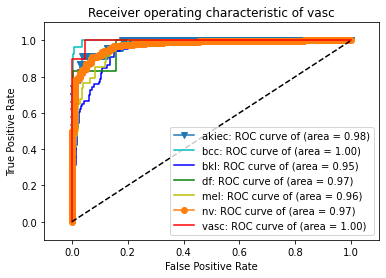

In [34]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()